In [1]:
import sys 
sys.path.append('../../')
import_path = '../export/'

In [2]:
import pandas as pd
import seaborn as sns

def load_dataset(datasetname):
    df = pd.read_csv(datasetname)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df
def load_plain_and_perturbed_dataset(epsilon):
    dataset_name1 = import_path + 'plain.csv'
    dataset_name2 = import_path + 'perturbed_' + str(epsilon) + '.csv'
    dataset1 = load_dataset(dataset_name1)
    dataset2 = load_dataset(dataset_name2)
    return dataset1, dataset2

def compare_datasets(dataset1, dataset2, epsilon):
    sns.scatterplot(data=dataset1, x='X', y='Y', label='baseline')
    sns.scatterplot(data=dataset2, x='X', y='Y', label='epsilon: {eps}'.format(eps=epsilon))

def load_and_compare(epsilon):
    dataset1, dataset2 = load_plain_and_perturbed_dataset(epsilon)
    compare_datasets(dataset1, dataset2, epsilon)

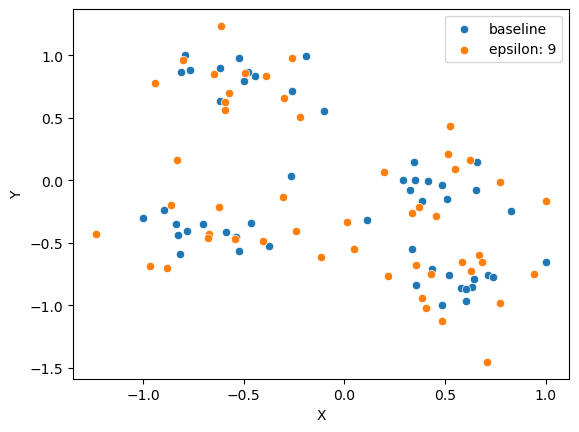

In [7]:
load_and_compare(9)

## Euclidean distance

In [8]:
epsilons = [0.05, 0.1, 0.5, 1, 2, 3, 5, 7, 9]
export_path = import_path + 'privacy_scores'

In [9]:
import numpy as np


def Euclidean_Dist(df1, df2, cols=['X','Y']):
    return np.average(np.linalg.norm(df1[cols] - df2[cols],
                   axis=1))
def calculate_avg_distance_between_datasets(epsilon):
    plain_df, perturbed_df = load_plain_and_perturbed_dataset(epsilon)
    return Euclidean_Dist(plain_df, perturbed_df)

def calculate_avg_distance_for_epsilons(epsilons):
    dict = {'epsilon': [], 'distance': []}
    for epsilon in epsilons:
        distance = calculate_avg_distance_between_datasets(epsilon)
        dict['epsilon'].append(epsilon)
        dict['distance'].append(distance)
    pd.DataFrame(dict).to_csv(export_path + '/report.csv')


In [10]:
calculate_avg_distance_for_epsilons(epsilons)

### Plot

In [11]:
distances_per_epsilon = load_dataset(export_path + '/report.csv')
distances_per_epsilon.head()

,epsilon,distance
0,0.05,36.104226
1,0.10,16.478947
2,0.50,3.498232
3,1.00,2.100088
4,2.00,0.967905


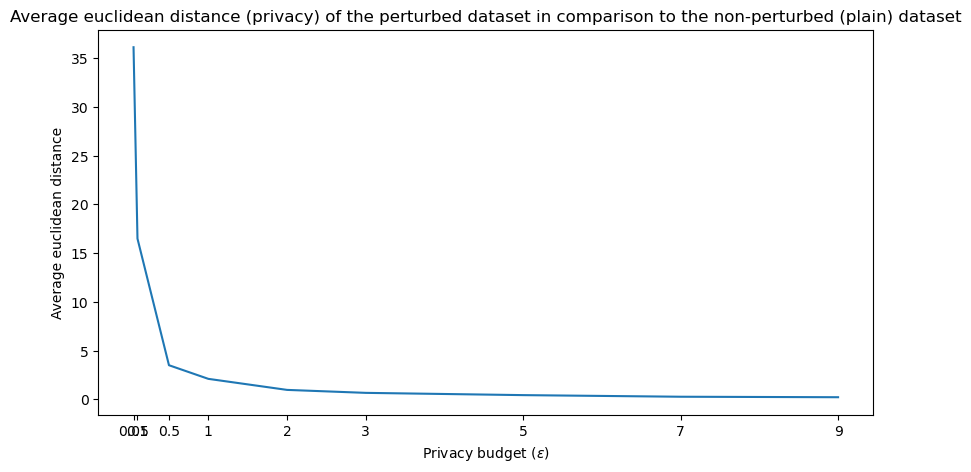

In [12]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Average euclidean distance (privacy) of the perturbed dataset in comparison to the non-perturbed (plain) dataset')
ax.set_ylabel('Average euclidean distance')
ax.set_xlabel('Privacy budget ($\epsilon$)')
ax.set_xticks(epsilons, labels=epsilons)
sns.lineplot(data=distances_per_epsilon, x='epsilon', y='distance', ax=ax, markers='True')
fig.savefig('../export/results/avg_euclidean.png')


## Other

In [1664]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from Helpers import twod_laplace
X, y_true = make_blobs(n_samples=1000, centers=4, n_features=2,
                       cluster_std=0.60, random_state=0)

_, _, Z = twod_laplace.generate_truncated_laplace_noise(X, 0.5)
Z_pd = pd.DataFrame(Z, columns=['X', 'Y'])
X_pd = pd.DataFrame(X, columns=['X', 'Y'])
create_labels = KMeans(init='random', n_clusters=4)
create_labels.fit(X_pd)
Z_pd['target'] = create_labels.labels_
X_pd['target'] = create_labels.labels_

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff17ed8ca0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff17ed8ca0>
Traceback 

In [1665]:
## train classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def train_model(X_train, y_train):
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    # test data for attack model

    return clf

In [1666]:
train_ratio = 0.25
shadow_ratio = 0.75
dataset = train_test_split(Z_pd.iloc[:, 0:2], Z_pd['target'], test_size=shadow_ratio)

# train is now 75% of the entire data set
x_target, x_shadow, y_target, y_shadow = dataset
# test is now 10% of the initial data set
# validation is now 15% of the initial data set
target_train_size = len(x_target) // 2
x_target_train = x_target[:target_train_size]
y_target_train = y_target[:target_train_size]
x_target_test = x_target[target_train_size:]
y_target_test = y_target[target_train_size:]

print(x_target.shape, x_shadow.shape)

(250, 2) (750, 2)


In [1667]:
# dataset = train_test_split(X, Y, test_size=0.50)
classifier = train_model(x_target_train, y_target_train)

In [1668]:
#shokri_mi_outputs = shokri_membership_inference(args, pred_y, membership, classes)
from art.estimators.classification.scikitlearn import ScikitlearnRandomForestClassifier

art_classifier = ScikitlearnRandomForestClassifier(classifier)
print('Base model accuracy:', classifier.score(x_target_test, y_target_test))


Base model accuracy: 0.496


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


In [1669]:
x_shadow_np = X_pd.iloc[x_shadow.index, 0:2].to_numpy()
y_shadow_np = X_pd.iloc[x_shadow.index, 2].to_numpy()

In [1670]:
from art.utils import to_categorical
from art.attacks.inference.membership_inference import ShadowModels

shadow_models = ShadowModels(art_classifier, num_shadow_models=3)
shadow_dataset = shadow_models.generate_shadow_dataset(x_shadow_np, to_categorical(y_shadow_np, 4))


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


In [1671]:
(member_x, member_y, member_predictions), (nonmember_x, nonmember_y, nonmember_predictions) = shadow_dataset
print([sm.model.score(x_target_test, y_target_test) for sm in shadow_models.get_shadow_models()])

[0.568, 0.552, 0.576]


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [1672]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

attack = MembershipInferenceBlackBox(art_classifier, attack_model_type="rf")
attack.fit(member_x, member_y, nonmember_x, nonmember_y, member_predictions, nonmember_predictions)

In [1673]:
member_infer = attack.infer(x_target_train, y_target_train)
nonmember_infer = attack.infer(x_target_test, y_target_test)
member_acc = np.sum(member_infer) / len(x_target_train)
nonmember_acc = 1 - np.sum(nonmember_infer) / len(x_target_test)
acc = (member_acc * len(x_target_train) + nonmember_acc * len(x_target_test)) / (len(x_target_train) + len(x_target_test))
print('Attack Member Acc:', member_acc)
print('Attack Non-Member Acc:', nonmember_acc)
print('Attack Accuracy:', acc)

Attack Member Acc: 0.128
Attack Non-Member Acc: 0.912
Attack Accuracy: 0.52


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [1674]:
def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1
    
    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall

In [1675]:
print(calc_precision_recall(np.concatenate((member_infer, nonmember_infer)), 
                            np.concatenate((np.ones(len(member_infer)), np.zeros(len(nonmember_infer))))))

(0.5925925925925926, 0.128)


In [1676]:
predicted_y = np.concatenate((member_infer, nonmember_infer))
actual_y = np.concatenate((np.ones(len(member_infer)), np.zeros(len(nonmember_infer))))

In [1677]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(actual_y, predicted_y, pos_label=1)


In [1678]:
print(tpr[1], fpr[1])

0.128 0.088


In [1679]:
attack_adv = tpr[1] - fpr[1]
attack_adv

0.04000000000000001

Text(0, 0.5, 'Privacy Leakage')

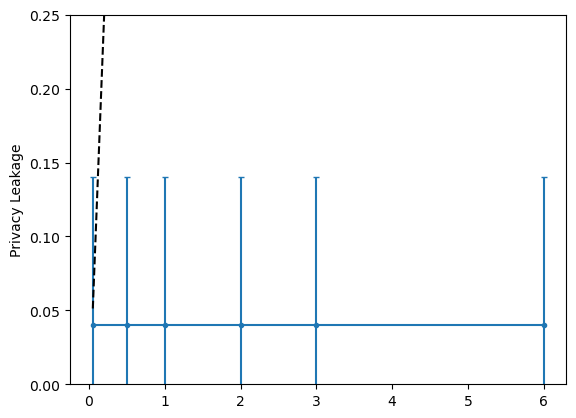

In [1680]:
def theoretical_limit(epsilons):
	return [np.exp(eps) - 1 for eps in epsilons]

def pretty_position(X, Y, pos):
	return ((X[pos] + X[pos+1]) / 2, (Y[pos] + Y[pos+1]) / 2)



bottom, top = plt.ylim()
plt.errorbar(epsilons, theoretical_limit(epsilons), color='black', fmt='--', capsize=2, label='Theoretical Limit')
plt.errorbar(epsilons, [attack_adv, attack_adv,attack_adv,attack_adv,attack_adv, attack_adv], yerr=0.1, fmt='.-', capsize=2)
plt.ylim(bottom, 0.25)
plt.annotate("$\epsilon$-DP Bound", pretty_position(epsilons, theoretical_limit(epsilons), 4), textcoords="offset points", xytext=(5,0), ha='left')
plt.yticks(np.arange(0, 0.26, step=0.05))
plt.ylabel('Privacy Leakage')

In [1681]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import numpy as np

from art.utils import load_nursery
X, y_true = make_blobs(n_samples=1000, centers=4, n_features=2,
                       cluster_std=0.60, random_state=0)

_, _, Z = twod_laplace.generate_truncated_laplace_noise(X, 0.02)
Z_pd = pd.DataFrame(Z, columns=['X', 'Y'])

dataset = train_test_split(Z_pd, y_true, test_size=0.5)

attack_train_ratio = 0.5
# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = dataset

attack_train_size = int(len(x_train) * attack_train_ratio)
attack_test_size = int(len(x_test) * attack_train_ratio)

bb_attack = MembershipInferenceBlackBox(art_classifier,attack_model_type="rf")

# train attack model
bb_attack.fit(x_train[:attack_train_size], y_train[:attack_train_size],
              x_test[:attack_test_size], y_test[:attack_test_size])

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [1682]:
# get inferred values
inferred_train_bb = bb_attack.infer(x_train[attack_train_size:], y_train[attack_train_size:])
inferred_test_bb = bb_attack.infer(x_test[attack_test_size:], y_test[attack_test_size:])
# check accuracy
train_acc = np.sum(inferred_train_bb) / len(inferred_train_bb)
test_acc = 1 - (np.sum(inferred_test_bb) / len(inferred_test_bb))
acc = (train_acc * len(inferred_train_bb) + test_acc * len(inferred_test_bb)) / (len(inferred_train_bb) + len(inferred_test_bb))
print(f"Members Accuracy: {train_acc:.4f}")
print(f"Non Members Accuracy {test_acc:.4f}")
print(f"Attack Accuracy {acc:.4f}")

Members Accuracy: 0.5040
Non Members Accuracy 0.5400
Attack Accuracy 0.5220


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [1683]:
# black-box
y_pred = np.concatenate((inferred_train_bb, inferred_test_bb))
y_actual = np.concatenate((np.ones(len(inferred_train_bb)), np.zeros(len(inferred_test_bb))))
print(calc_precision_recall(y_pred, y_actual))

(0.5228215767634855, 0.504)


In [1684]:
tpr, fpr, _ = roc_curve(y_actual, y_pred, pos_label=1)

In [1685]:
tpr[1] - fpr[1]

-0.043999999999999984

In [1686]:
import warnings
from sklearn.metrics import accuracy_score, log_loss

from sklearn.naive_bayes import GaussianNB

    
def train_classic(dataset, model, silent=True, privacy='no_privacy', preprocess=None, dp='dp', epsilon=0.5, delta=1e-5, resource_tracker=None):

    train_x, train_y, test_x, test_y = dataset
    n_out = 4
    n_in = train_x.shape[1]

    permissible_models = {
        'rndf': RandomForestClassifier,
        'nb': GaussianNB,
    }
    
    model_params = {
        'rndf': {'n_estimators': 100, 'max_depth': 15},
        'nb': {'var_smoothing': 1e-9},
        'lr': {'solver':'lbfgs', 'multi_class':'ovr', 'penalty':'l2', 'max_iter':1000, 'n_jobs':-1},
        'dp-rndf': {'epsilon': epsilon,
                    'n_labels': len(set(train_y)),
                    'num_trees': 100,
                    'MULTI_THREAD': True,
                    'pool_size': 20},
    }
    
    # Check that our input data is valid
    #assert (np.isfinite(train_x).all())
    #assert (np.isfinite(test_x).all())
    
    print(model)
    print(privacy)
    
    if (model == 'ibmNB') and (privacy == 'no_privacy'):
        print('Substituting regular NB for no-privacy IBM-NB')
        classifier = permissible_models['nb'](**model_params['nb'])
    elif (model == 'ibmLR') and (privacy == 'no_privacy'):
        print('Substituting regular LR for no-privacy IBM-LR')
        classifier =  permissible_models['lr'](**model_params['lr'])
    elif (model == 'dp-rndf') and (privacy == 'no_privacy'):
        print('Substituting regular RNDF for no-privacy DP-RNDF')
        params = model_params['rndf'].copy()
        # Fixed max depth due to DP implementation having a max depth of 15.
        params['max_depth'] = 15
        classifier = permissible_models['rndf'](**params)
    else:
        classifier = permissible_models[model](**model_params[model])

    print("Start Training model")
        
    if preprocess is None:
        if resource_tracker is not None:
            resource_tracker.create_checkpoint('start_training')
        ##
        classifier.fit(train_x, train_y)
        ##
        if resource_tracker is not None:
            resource_tracker.create_checkpoint('end_training')

    else:
        def preprocess_data(preprocess, x, eps):
            # Transform x, or y, but ensure the shape and datastructure is maintained
            if preprocess == 'dp-noise':
                # assert False, 'Not implemented'
                S = x.max(axis=0) - x.min(axis=0)
                B = S/(eps/x.shape[1])
                noise = np.random.laplace(0, B, (x.shape))
                assert x.shape == noise.shape
                x_dash = x + noise
                assert x_dash.shape == x.shape
            else:
                assert False, 'Invalid Preprocess'
                pass
            assert(x.shape == (x_dash.shape)), 'Pre-processing has not preserved shape of datastructure'

            return x_dash
        
        if resource_tracker is not None:
            resource_tracker.create_checkpoint('start_preprocess')
        ##
        train_x_dash = preprocess_data(preprocess, train_x, epsilon)
        ##
        if resource_tracker is not None:
            resource_tracker.create_checkpoint('end_process')

        if resource_tracker is not None:
            resource_tracker.create_checkpoint('start_training')
        ##
        classifier.fit(train_x_dash, train_y)
        ##
        if resource_tracker is not None:
            resource_tracker.create_checkpoint('end_training')


    
    print("Start finding Train Accuracy")
    # predict and process the training data
    predict_x_labels = classifier.predict(train_x)
    train_acc = accuracy_score(train_y, predict_x_labels)
    predict_x_probs = classifier.predict_proba(train_x)

    print("compute train log-loss")
    try:
        train_loss = log_loss(train_y, predict_x_probs)
    except:
        warnings.warn("nan confidence values encountered, values have been filled with 1.0/n_classes", RuntimeWarning)
        wher_isnan = np.isnan(predict_x_probs)
        predict_x_probs[wher_isnan] = 1.0/n_out
        train_loss = log_loss(train_y, predict_x_probs)

    if not silent:
        print('Train accuracy is: %.3f' % (train_acc))

    print("Start finding Test Accuracy")
        
    # predict and process the testing data
    predict_x_labels = classifier.predict(test_x)
    test_acc = accuracy_score(test_y, predict_x_labels)
    if not silent:
        print('Test accuracy is: %.3f' % (test_acc))

    if resource_tracker is not None:
        resource_tracker.create_checkpoint('end_predictions')
        
#     predict_x_probs = classifier.predict_proba(test_x)

#     print("compute test log-loss")
#     try:
#         test_loss = log_loss(test_y, predict_x_probs)
#     except:
#         warnings.warn("nan confidence values encountered, values have been filled with 1.0/n_classes", RuntimeWarning)
#         wher_isnan = np.isnan(predict_x_probs)
#         print(wher_isnan)
#         predict_x_probs[wher_isnan] = 1.0/n_out
#         test_loss = log_loss(test_y, predict_x_probs)


#     # pred_scores contains the confidence values.
#     pred_scores = predict_x_probs
#     # pred_y contains the predicted label
#     pred_y = predict_x_labels

    return classifier, None, None, train_loss, train_acc, test_acc
    


def train_classic_target_model(dataset, l2_ratio=1e-7, model='nn', save=True,
                               privacy='no_privacy', preprocess=None, dp='dp', epsilon=0.5, delta=1e-5, resource_tracker=None):

    train_x, train_y, test_x, test_y = dataset
    n_classes = 4
    a = train_classic(dataset, model=model, silent=False,
                            privacy=privacy, preprocess=preprocess, dp=dp, epsilon=epsilon, delta=delta,         
                            resource_tracker=resource_tracker)
    classifier, _, _, train_loss, train_acc, test_acc = a

    # test data for attack model
    attack_x, attack_y = [], []

    # data used in training, label is 1
    pred_scores = classifier.predict_proba(train_x)
    nan_vals = np.isnan(pred_scores)
    if nan_vals.any():
        warnings.warn("nan confidence values encountered, values have been filled with 1.0/n_classes", RuntimeWarning)
        pred_scores[nan_vals] = 1.0/n_classes
    attack_x.append(pred_scores)
    attack_y.append(np.ones(train_x.shape[0]))

    # data not used in training, label is 0
    pred_scores = classifier.predict_proba(test_x)
    nan_vals = np.isnan(pred_scores)
    if nan_vals.any():
        warnings.warn("nan confidence values encountered, values have been filled with 1.0/n_classes", RuntimeWarning)
        pred_scores[nan_vals] = 1.0/n_classes
    attack_x.append(pred_scores)
    attack_y.append(np.zeros(test_x.shape[0]))

    attack_x = np.vstack(attack_x)
    attack_y = np.concatenate(attack_y)
    attack_x = attack_x.astype('float32')
    attack_y = attack_y.astype('int32')

    assert save == False, "Defunct option"

    classes = np.concatenate([train_y, test_y])
    return attack_x, attack_y, classes, train_loss, classifier, train_acc, test_acc
    
pred_y, membership, test_classes, train_loss, classifier, train_acc, test_acc = train_classic_target_model(
            dataset=dataset,
            model='rndf')


rndf
no_privacy
Start Training model


ValueError: Unknown label type: 'continuous-multioutput'